In [1]:
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
import geopandas as gpd

spark = SparkSession. \
    builder. \
    appName('Milestone4 - Airline Search'). \
    master('spark://DESKTOP-DBR5VTD.localdomain:7077'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.0.1-incubating,'
           'org.datasyslab:geotools-wrapper:geotools-24.1'). \
    getOrCreate()

SedonaRegistrator.registerAll(spark)

21/11/22 22:58:52 WARN Utils: Your hostname, DESKTOP-DBR5VTD resolves to a loopback address: 127.0.1.1; using 10.189.49.10 instead (on interface wifi0)
21/11/22 22:58:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/root/spark-3.0.3-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-dd4b7970-a2f9-4acd-8345-be93da94643e;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.0.1-incubating in central
	found org.locationtech.jts#jts-core;1.18.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found com.fasterxml.jackson.core#jackson-databind;2.12.2 in central
	found com.fasterxml.

True

In [2]:
!wget https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/boundary-each-state.tsv

--2021-11-22 22:59:05--  https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/boundary-each-state.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60085 (59K) [text/plain]
Saving to: ‘boundary-each-state.tsv’

boundary-each-state 100%[===================>]  58.68K  --.-KB/s    in 0.01s   

2021-11-22 22:59:05 (5.04 MB/s) - ‘boundary-each-state.tsv’ saved [60085/60085]



In [3]:
!wget https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/cities.csv

--2021-11-22 22:59:06--  https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/cities.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60 [text/plain]
Saving to: ‘cities.csv’

cities.csv          100%[===================>]      60  --.-KB/s    in 0s      

2021-11-22 22:59:06 (623 KB/s) - ‘cities.csv’ saved [60/60]



In [4]:
states_wkt = spark.read.option("delimiter", "\t").option("header", "false").csv("boundary-each-state.tsv").toDF("s_name","s_bound")
states_wkt.show()
states_wkt.printSchema()

states = states_wkt.selectExpr("s_name", "ST_GeomFromWKT(s_bound) as s_bound")
states.show()
states.printSchema()
states.createOrReplaceTempView("states")

+-------------+--------------------+
|       s_name|             s_bound|
+-------------+--------------------+
|       Alaska|POLYGON((-141.020...|
|      Alabama|POLYGON((-88.1955...|
|     Arkansas|POLYGON((-94.0416...|
|      Arizona|POLYGON((-112.598...|
|   California|POLYGON((-124.400...|
|     Colorado|POLYGON((-109.044...|
|  Connecticut|POLYGON((-73.4875...|
|     Delaware|POLYGON((-75.7919...|
|      Florida|POLYGON((-87.6050...|
|      Georgia|POLYGON((-85.6082...|
|       Hawaii|POLYGON((-154.628...|
|         Iowa|POLYGON((-95.7623...|
|        Idaho|POLYGON((-117.031...|
|     Illinois|POLYGON((-90.6290...|
|      Indiana|POLYGON((-87.5253...|
|       Kansas|POLYGON((-102.050...|
|     Kentucky|POLYGON((-89.5372...|
|    Louisiana|POLYGON((-94.0430...|
|Massachusetts|POLYGON((-72.7789...|
|     Maryland|POLYGON((-79.4778...|
+-------------+--------------------+
only showing top 20 rows

root
 |-- s_name: string (nullable = true)
 |-- s_bound: string (nullable = true)

+--

In [5]:
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

--2021-11-22 22:59:08--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127225 (1.1M) [text/plain]
Saving to: ‘airports.dat’

airports.dat        100%[===================>]   1.07M  --.-KB/s    in 0.07s   

2021-11-22 22:59:09 (15.3 MB/s) - ‘airports.dat’ saved [1127225/1127225]



In [6]:
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat

--2021-11-22 22:59:09--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396896 (388K) [text/plain]
Saving to: ‘airlines.dat’

airlines.dat        100%[===================>] 387.59K  --.-KB/s    in 0.04s   

2021-11-22 22:59:09 (8.59 MB/s) - ‘airlines.dat’ saved [396896/396896]



In [7]:
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

--2021-11-22 22:59:09--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2377148 (2.3M) [text/plain]
Saving to: ‘routes.dat’

routes.dat          100%[===================>]   2.27M  --.-KB/s    in 0.1s    

2021-11-22 22:59:09 (19.9 MB/s) - ‘routes.dat’ saved [2377148/2377148]



In [8]:
airport_dat = spark.read.option("delimiter", ",").option("header", "false").csv("airports.dat").toDF("AirportID","Name"
,"City","Country","IATA","ICAO","Latitude","Longitude","Altitude","Timezone","DST","Database Time Zone","Type","Source")
airport_dat = airport_dat.drop("Source")
airport_dat = airport_dat.drop("Type")
airport_dat = airport_dat.drop("Database Time Zone")
airport_dat = airport_dat.drop("DST")
airport_dat = airport_dat.drop("Timezone")
airport_dat = airport_dat.drop("Altitude")
airport_dat = airport_dat.fillna('N/A')
airport_dat = airport_dat.na.replace("\\N","N/A")
airport_dat = airport_dat.na.replace("-","N/A")

from pyspark.sql import functions
airport = airport_dat.select("AirportID", "Name", "City", "Country","IATA","ICAO",
                                 functions.concat_ws("_",airport_dat.Longitude,airport_dat.Latitude).alias("Location"))

airport = airport.selectExpr("*", "ST_PointFromText(Location, \'_\') as geospacial_Location")
airport = airport.drop("Location")
airport.createOrReplaceTempView("airport")
airport.show()
airport.printSchema()

+---------+--------------------+--------------+----------------+----+----+--------------------+
|AirportID|                Name|          City|         Country|IATA|ICAO| geospacial_Location|
+---------+--------------------+--------------+----------------+----+----+--------------------+
|        1|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA|POINT (145.391998...|
|        2|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD|POINT (145.789001...|
|        3|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea| HGU|AYMH|POINT (144.296005...|
|        4|      Nadzab Airport|        Nadzab|Papua New Guinea| LAE|AYNZ|POINT (146.725977...|
|        5|Port Moresby Jack...|  Port Moresby|Papua New Guinea| POM|AYPY|POINT (147.220001...|
|        6|Wewak Internation...|         Wewak|Papua New Guinea| WWK|AYWK|POINT (143.669006...|
|        7|  Narsarsuaq Airport|  Narssarssuaq|       Greenland| UAK|BGBW|POINT (-45.425998...|
|        8|Godthaab / Nuuk A...|      Go

In [9]:
airline_dat = spark.read.option("delimiter", ",").option("header", "false").csv("airlines.dat").toDF("AirlineID","Name"
,"Alias","IATA","ICAO","Callsign","Country","Active")
airline_dat = airline_dat.fillna('N/A')
airline_dat = airline_dat.na.replace("\\N","N/A")
airline_dat = airline_dat.na.replace("-","N/A")
airline_dat = airline_dat.drop("Callsign")
airline_dat.createOrReplaceTempView("airline")
airline_dat = spark.sql("select * from airline where AirlineID > 0")
airline_dat.show()
airline_dat.printSchema()
airline = airline_dat

+---------+--------------------+-----+----+----+--------------+------+
|AirlineID|                Name|Alias|IATA|ICAO|       Country|Active|
+---------+--------------------+-----+----+----+--------------+------+
|        1|      Private flight|  N/A| N/A| N/A|           N/A|     Y|
|        2|         135 Airways|  N/A| N/A| GNL| United States|     N|
|        3|       1Time Airline|  N/A|  1T| RNX|  South Africa|     Y|
|        4|2 Sqn No 1 Elemen...|  N/A| N/A| WYT|United Kingdom|     N|
|        5|     213 Flight Unit|  N/A| N/A| TFU|        Russia|     N|
|        6|223 Flight Unit S...|  N/A| N/A| CHD|        Russia|     N|
|        7|   224th Flight Unit|  N/A| N/A| TTF|        Russia|     N|
|        8|         247 Jet Ltd|  N/A| N/A| TWF|United Kingdom|     N|
|        9|         3D Aviation|  N/A| N/A| SEC| United States|     N|
|       10|         40-Mile Air|  N/A|  Q5| MLA| United States|     Y|
|       11|              4D Air|  N/A| N/A| QRT|      Thailand|     N|
|     

In [10]:
route_dat = spark.read.option("delimiter", ",").option("header", "false").csv("routes.dat").toDF("Airline","AirlineID"
,"SourceAirport","SourceAirportID","DestinationAirport","DestinationAirportID","Codeshare","Stops","Equipment")
route_dat = route_dat.drop("Equipment")
route_dat = route_dat.fillna('N/A')
route_dat = route_dat.na.replace("\\N","N/A")
route_dat = route_dat.na.replace("-","N/A")
route_dat.createOrReplaceTempView("route")
#route_dat.show()
#route_dat.printSchema()

route = route_dat
route.show()

+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|Airline|AirlineID|SourceAirport|SourceAirportID|DestinationAirport|DestinationAirportID|Codeshare|Stops|
+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|     2B|      410|          AER|           2965|               KZN|                2990|      N/A|    0|
|     2B|      410|          ASF|           2966|               KZN|                2990|      N/A|    0|
|     2B|      410|          ASF|           2966|               MRV|                2962|      N/A|    0|
|     2B|      410|          CEK|           2968|               KZN|                2990|      N/A|    0|
|     2B|      410|          CEK|           2968|               OVB|                4078|      N/A|    0|
|     2B|      410|          DME|           4029|               KZN|                2990|      N/A|    0|
|     2B|      410|          DME|           40

In [11]:
airport.count()

7698

In [12]:
airline.count()

6161

In [13]:
route.count()

67663

In [14]:
airline_cp = spark.sql("Select * from airline where airline.IATA != 'N/A'")
airline_cp = airline_cp.withColumnRenamed("IATA","Airline")

In [15]:
route_cp = route.alias('r').join(airline_cp.alias('a'), on = 'Airline', how = 'left')\
    .select('r.Airline', functions.when(~functions.isnull(functions.col('a.AirlineID')),
                                       functions.col('a.AirlineID')
                                       ).otherwise(functions.col('r.AirlineID')).alias('AirlineID'),
            #'r.AirlineID', 'a.AirlineID',
           'r.SourceAirport', 'r.SourceAirportID', 'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

In [16]:
route_cp.count()

78221

In [17]:
airline_cp = spark.sql("Select * from airline where airline.ICAO != 'N/A'")
airline_cp = airline_cp.withColumnRenamed("ICAO","Airline")

In [18]:
route_cp = route_cp.alias('r').join(airline_cp.alias('a'), on = 'Airline', how = 'left')\
    .select('r.Airline', functions.when(~functions.isnull(functions.col('a.AirlineID')),
                                       functions.col('a.AirlineID')
                                       ).otherwise(functions.col('r.AirlineID')).alias('AirlineID'),
           'r.SourceAirport', 'r.SourceAirportID', 'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()


In [19]:
airport_cp = spark.sql("Select * from airport where airport.IATA != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("IATA","SourceAirport")

In [20]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), 
                                    
                                    on = 'SourceAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.SourceAirportID')).alias('SourceAirportID'), 
            'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

In [21]:
airport_cp = spark.sql("Select * from airport where airport.ICAO != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("ICAO","SourceAirport")

In [22]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'SourceAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.SourceAirportID')).alias('SourceAirportID'), 
            'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

In [23]:
airport_cp = spark.sql("Select * from airport where airport.IATA != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("IATA","DestinationAirport")

In [24]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'DestinationAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', 'r.SourceAirportID',
            'r.DestinationAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.DestinationAirportID')).alias('DestinationAirportID'),
           'r.Codeshare', 'r.Stops').dropDuplicates()

In [25]:
route_cp.count()

78221

In [26]:
airport_cp = spark.sql("Select * from airport where airport.ICAO != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("ICAO","DestinationAirport")

In [27]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'DestinationAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', 'r.SourceAirportID',
            'r.DestinationAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.DestinationAirportID')).alias('DestinationAirportID'),
           'r.Codeshare', 'r.Stops').dropDuplicates().sort("Airline")

In [28]:
route_cp.show()

+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|Airline|AirlineID|SourceAirport|SourceAirportID|DestinationAirport|DestinationAirportID|Codeshare|Stops|
+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|     2B|      410|          LED|           2948|               NBC|                6969|      N/A|    0|
|     2B|      410|          LED|           2948|               KZN|                2990|      N/A|    0|
|     2B|      410|          NUX|           4364|               SVX|                2975|      N/A|    0|
|     2B|      410|          KZN|           2990|               AER|                2965|      N/A|    0|
|     2B|      410|          UUA|           6160|               LED|                2948|      N/A|    0|
|     2B|      410|          KZN|           2990|               LED|                2948|      N/A|    0|
|     2B|      410|          KZN|           29

In [29]:
airport_cp = spark.sql("Select AirportID, Name, City, Country from airport where airport.Country != 'N/A'")
X = input("Enter country's name: ")
airport_cp.filter(airport_cp.Country.rlike(f"(?i)^*{X}$")).show()

Enter country's name: United States
+---------+--------------------+----------------+-------------+
|AirportID|                Name|            City|      Country|
+---------+--------------------+----------------+-------------+
|     3411|Barter Island LRR...|   Barter Island|United States|
|     3412|Wainwright Air St...| Fort Wainwright|United States|
|     3413|Cape Lisburne LRR...|   Cape Lisburne|United States|
|     3414|Point Lay LRRS Ai...|       Point Lay|United States|
|     3415|Hilo Internationa...|            Hilo|United States|
|     3416|Orlando Executive...|         Orlando|United States|
|     3417|     Bettles Airport|         Bettles|United States|
|     3418|       Clear Airport|      Clear Mews|United States|
|     3419|Indian Mountain L...|Indian Mountains|United States|
|     3420|  Fort Yukon Airport|      Fort Yukon|United States|
|     3421|Sparrevohn LRRS A...|      Sparrevohn|United States|
|     3422|Bryant Army Heliport| Fort Richardson|United States|
|   

In [30]:
from pyspark.sql.functions import when
route_cp.createOrReplaceTempView("route_cp")
X = input("Enter # stops: ")
newRoute = spark.sql(f"Select AirlineID, Stops from route_cp where route_cp.Stops == {X}")
airline_cp = spark.sql(f"Select AirlineID, Name, Alias from airline")
newRoute = newRoute.alias('r').join(airline_cp.alias('a'), on = 'AirlineID', how = 'inner')\
    .select('r.AirlineID', when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise("a.Alias").alias('Airline_Name'),
'r.Stops').dropDuplicates()
newRoute.filter(newRoute.Airline_Name != 'N/A').show()

Enter # stops: 1


+---------+--------------------+-----+
|AirlineID|        Airline_Name|Stops|
+---------+--------------------+-----+
|     1316|     AirTran Airways|    1|
|     1936|  Cubana de Aviación|    1|
|     4319|Scandinavian Airl...|    1|
|     1623|      Canadian North|    1|
|      330|          Air Canada|    1|
|     4547|  Southwest Airlines|    1|
+---------+--------------------+-----+



In [31]:
newRoute = spark.sql(f"Select AirlineID, Codeshare from route_cp where route_cp.Codeshare == 'Y' \
                     or route_cp.Codeshare == 'y'")
airline_cp = spark.sql(f"Select AirlineID, Name, Alias from airline")
airline_cp = newRoute.alias('r').join(airline_cp.alias('a'), on = 'AirlineID', how = 'inner')\
    .select('r.AirlineID', when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise("a.Alias").alias('Airline_Name'),
'r.Codeshare').dropDuplicates()
airline_cp.filter(airline_cp.Airline_Name != 'N/A').show()

+---------+--------------------+---------+
|AirlineID|        Airline_Name|Codeshare|
+---------+--------------------+---------+
|     5179|               Tarom|        Y|
|      502|Abu Dhabi Amiri F...|        Y|
|      324|  All Nippon Airways|        Y|
|     2855|              Indigo|        Y|
|     5416|             WestJet|        Y|
|     5347|Virgin Atlantic A...|        Y|
|     1889|       Copa Airlines|        Y|
|     2421|               Flybe|        Y|
|     4559|Swiss Internation...|        Y|
|       28|     Asiana Airlines|        Y|
|     5309|    Vietnam Airlines|        Y|
|     1942|      Cyprus Airways|        Y|
|      137|          Air France|        Y|
|      241|          Air Sahara|        Y|
|     3378|   Malaysia Airlines|        Y|
|     1908|          Corsairfly|        Y|
|     1317|         Air Transat|        Y|
|     4292|    Rwandair Express|        Y|
|      197| Azerbaijan Airlines|        Y|
|     2056|           Dragonair|        Y|
+---------+

In [32]:
airline_cp = spark.sql("""
                       Select AirlineID, Name, Alias, Country, Active 
                       from airline 
                       where Country == 'United States' and (Active == 'Y' or Active == 'y')
                       """)
airline_cp = airline_cp.select(airline_cp.AirlineID, when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise(airline_cp.Alias).alias('Airline_Name'), airline_cp.Country, airline_cp.Active)
airline_cp.filter(airline_cp.Airline_Name != 'N/A').show()

+---------+--------------------+-------------+------+
|AirlineID|        Airline_Name|      Country|Active|
+---------+--------------------+-------------+------+
|       10|         40-Mile Air|United States|     Y|
|       22|      Aloha Airlines|United States|     Y|
|       24|   American Airlines|United States|     Y|
|       35|       Allegiant Air|United States|     Y|
|      109|Alaska Central Ex...|United States|     Y|
|      149|  Air Cargo Carriers|United States|     Y|
|      210|Airlift Internati...|United States|     Y|
|      281|America West Airl...|United States|     Y|
|      282|       Air Wisconsin|United States|     Y|
|      287|Allegheny Commute...|United States|     Y|
|      295|        Air Sunshine|United States|     Y|
|      315|        ATA Airlines|United States|     Y|
|      397|           Arrow Air|United States|     Y|
|      452|Atlantic Southeas...|United States|     Y|
|      659|American Eagle Ai...|United States|     Y|
|      792|          Access 

In [33]:
airport_cp = spark.sql("""
                select Country, count(Country) as Num_Airports
                from airport
                where country != 'N/A'
                group by Country
                order by Num_Airports desc
            """)
airport_cp.first()

Row(Country='United States', Num_Airports=1512)

In [34]:
airline_cp = spark.sql("""
                       Select AirlineID, DestinationAirportID 
                       from route_cp 
                       where AirlineID != 'N/A' and DestinationAirportID != 'N/A'
                       """)
airline_cp.createOrReplaceTempView("airline_cp")
airport_cp = spark.sql("""
                       Select AirportID, City
                       from airport 
                       where City != 'N/A'
                       """)
airport_cp.createOrReplaceTempView("airport_cp")
result = spark.sql("""
            Select airport_cp.City, count(distinct airline_cp.AirlineID) as Num_Airlines
            from airline_cp
            inner join airport_cp
            on airline_cp.DestinationAirportID == airport_cp.AirportID
            group by airport_cp.City
            order by Num_Airlines desc
    """)
topIncomingAirport=result.limit(10)
result.show()

+---------+------------+
|     City|Num_Airlines|
+---------+------------+
|    Paris|         147|
|   London|         139|
|   Moscow|         132|
|  Bangkok|         126|
|Frankfurt|         111|
|     Rome|         103|
| Istanbul|          99|
|    Dubai|          97|
|Hong Kong|          97|
|Singapore|          94|
|Amsterdam|          93|
|   Munich|          93|
|  Beijing|          91|
| New York|          86|
|Barcelona|          85|
|   Milano|          85|
|   Zurich|          83|
|   Vienna|          83|
| Shanghai|          82|
|    Tokyo|          82|
+---------+------------+
only showing top 20 rows



In [35]:
X = input("Enter city's longitude: ")
Y = input("Enter country's latitude: ")

airport_cp = spark.sql("""
    select AirportID,Name,City,Country,geospacial_Location
    from airport
    where City != 'N/A'
""")
airport_cp.createOrReplaceTempView("airport_cp")
result = spark.sql(f" \
    select a.AirportID, a.Name, a.City, a.Country,a.geospacial_Location, ST_Distance(a.geospacial_Location, ST_Point({X}, {Y})) as Distance \
    from airport as a \
    order by Distance")
closestAirport=result.limit(10)
closestAirport2 = gpd.GeoDataFrame(result.limit(100).toPandas(), geometry="geospacial_Location")
result.show()

Enter city's longitude: 105.65
Enter country's latitude: 35.689
+---------+--------------------+----------------+-------+--------------------+------------------+
|AirportID|                Name|            City|Country| geospacial_Location|          Distance|
+---------+--------------------+----------------+-------+--------------------+------------------+
|     8971|Guyuan Liupanshan...|          Guyuan|  China|POINT (106.216944...|0.6880692903117746|
|     8889|Tianshui Maijisha...|        Tianshui|  China|POINT (105.860000...| 1.148955814484211|
|     6431|Lanzhou City Airport|         Lanzhou|  China|POINT (103.86667 ...| 1.816268455870173|
|    13471|Longnan Chengzhou...|         Longnan|  China|POINT (105.797 33...|1.9066751165313955|
|     8043|Zhongwei Shapotou...|        Zhongwei|  China|POINT (105.154454...|1.9482024673377751|
|     6365|    Qingyang Airport|        Qingyang|  China|POINT (107.602997...|1.9561319523010166|
|     3378|Lanzhou Zhongchua...|         Lanzhou|  Chi

In [36]:
airportInState = spark.sql("""
    select s.s_name as States, a.AirportID, a.Name, a.City
    from states as s, airport as a
    where ST_Contains(s.s_bound, a.geospacial_Location)
""")
airportInState.show()

21/11/22 23:02:27 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


+-------------+---------+--------------------+----------------+
|       States|AirportID|                Name|            City|
+-------------+---------+--------------------+----------------+
|       Alaska|     3411|Barter Island LRR...|   Barter Island|
|       Alaska|     3412|Wainwright Air St...| Fort Wainwright|
|       Alaska|     3413|Cape Lisburne LRR...|   Cape Lisburne|
|       Alaska|     3414|Point Lay LRRS Ai...|       Point Lay|
|       Hawaii|     3415|Hilo Internationa...|            Hilo|
|      Florida|     3416|Orlando Executive...|         Orlando|
|       Alaska|     3417|     Bettles Airport|         Bettles|
|       Alaska|     3418|       Clear Airport|      Clear Mews|
|       Alaska|     3419|Indian Mountain L...|Indian Mountains|
|       Alaska|     3420|  Fort Yukon Airport|      Fort Yukon|
|       Alaska|     3421|Sparrevohn LRRS A...|      Sparrevohn|
|       Alaska|     3422|Bryant Army Heliport| Fort Richardson|
|       Alaska|     3423|Tatalina LRRS A

In [37]:
airportInState = spark.sql("""
    select s.s_name as States, a.AirportID, a.Name, a.City, s.s_bound
    from states as s, airport as a
    where ST_Contains(s.s_bound, a.geospacial_Location)
""")
geopandas_df = gpd.GeoDataFrame(airportInState.toPandas(), geometry="s_bound")
geopandas_df

21/11/22 23:02:28 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


,States,AirportID,Name,City,s_bound
0,Alaska,3411,Barter Island LRRS Airport,Barter Island,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
1,Alaska,3412,Wainwright Air Station,Fort Wainwright,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
2,Alaska,3413,Cape Lisburne LRRS Airport,Cape Lisburne,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
3,Alaska,3414,Point Lay LRRS Airport,Point Lay,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
4,Hawaii,3415,Hilo International Airport,Hilo,"POLYGON ((-154.62840 19.51580, -154.82350 19.8..."
...,...,...,...,...,...
1504,California,13717,Camp Pendleton MCAS (Munn Field) Airport,Oceanside,"POLYGON ((-124.40090 41.99830, -123.62370 42.0..."
1505,Georgia,13757,Vidalia Regional Airport,Vidalia,"POLYGON ((-85.60820 34.99740, -84.72660 34.990..."
1506,Texas,13758,Granbury Regional Airport,Granbury,"POLYGON ((-106.57150 31.86590, -106.50420 31.7..."
1507,New York,13759,Oswego County Airport,Fulton,"POLYGON ((-79.76240 42.51420, -79.06720 42.778..."


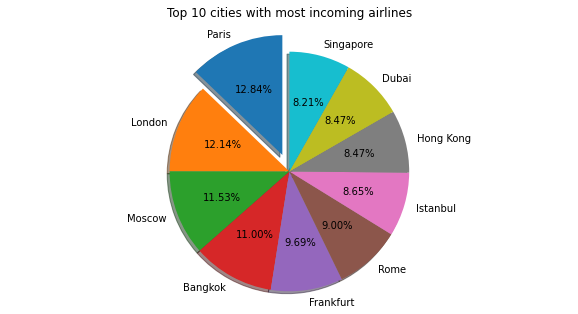

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery-nogrid')

keyList = [x['City'] for x in topIncomingAirport.collect()]
valueList = [x['Num_Airlines'] for x in topIncomingAirport.collect()]
labels = keyList
sizes = valueList

explode = (0.15, 0, 0, 0, 0, 0, 0, 0, 0 ,0) 
plt.rcParams['figure.figsize']=[8,4]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Top 10 cities with most incoming airlines')

plt.show()

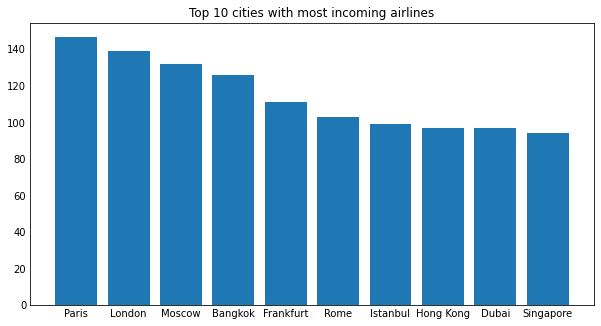

In [39]:
keyList = [x['City'] for x in topIncomingAirport.collect()]
valueList = [x['Num_Airlines'] for x in topIncomingAirport.collect()]
x = keyList
y = valueList
plt.bar(x,y)
plt.title('Top 10 cities with most incoming airlines')
plt.show()

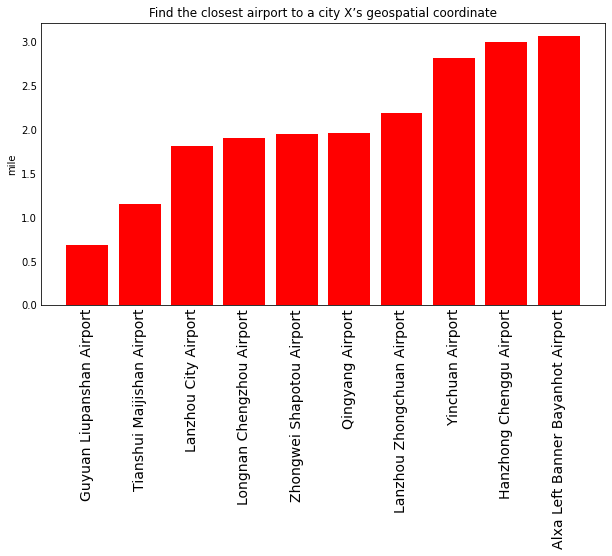

In [40]:
import matplotlib.pyplot as plt
import matplotlib
keyList = [x['Name'] for x in closestAirport.collect()]
valueList = [x['Distance'] for x in closestAirport.collect()]
x = keyList
y = valueList
plt.xticks(rotation=90, fontsize=14)
plt.bar(x,y,color='red')
plt.ylabel('mile')
plt.title('Find the closest airport to a city X’s geospatial coordinate')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

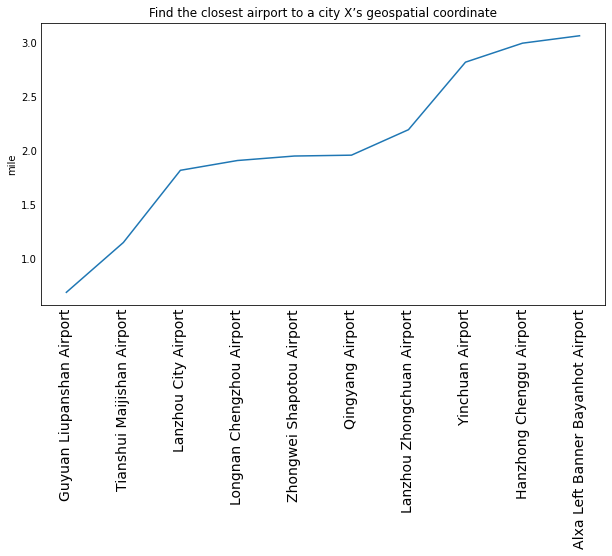

In [41]:
import matplotlib.pyplot as plt
keyList = [x['Name'] for x in closestAirport.collect()]
valueList = [x['Distance'] for x in closestAirport.collect()]
x = keyList
y = valueList
plt.xticks(rotation=90, fontsize=14)
plt.plot(x,y)
plt.ylabel('mile')
plt.title('Find the closest airport to a city X’s geospatial coordinate')
plt.show

<AxesSubplot:>

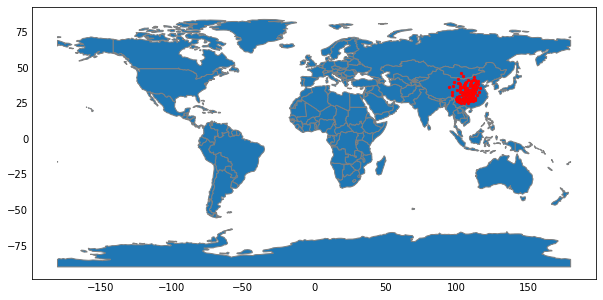

In [48]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(edgecolor='#808080')
closestAirport2.plot(ax=base, marker='o', color='red', markersize=5)

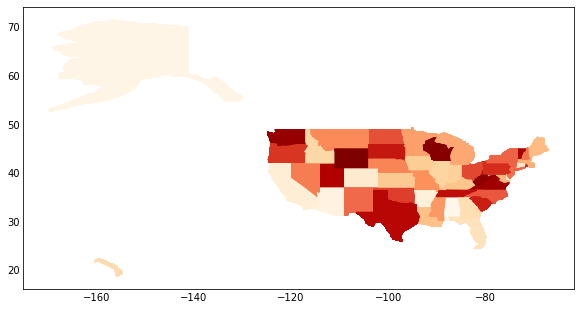

In [44]:
geopandas_df['airport_per_state'] = geopandas_df.States
geopandas_df.plot(column='airport_per_state', cmap='OrRd');